In [7]:
!pip install notebook
!pip install pandas numpy scikit-learn matplotlib



^C



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

In [3]:
#dataset paths
data_path_train = r'C:\Users\felix\PycharmProjects\INSAResearchProject\data\nsl-kdd\KDDTrain+.txt'
data_path_test = r'C:\Users\felix\PycharmProjects\INSAResearchProject\data\nsl-kdd\KDDTest+.txt'

#names for the columns
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
    "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]

#Load datasets
df_train = pd.read_csv(data_path_train, header=None, names=column_names, usecols=range(len(column_names)))
df_test = pd.read_csv(data_path_test, header=None, names=column_names, usecols=range(len(column_names)))
# Read the datasets without specifying column names
train_raw = pd.read_csv(data_path_train, header=None)
test_raw = pd.read_csv(data_path_test, header=None)

#Extract the label column (last column in the NSL- KDD dataset) 
train_label_distribution = train_raw.iloc[:, -1].value_counts()
test_label_distribution = test_raw.iloc[:, -1].value_counts()

#create binary lables by chaniging anything non normal to anomaly label
def map_to_binary(label):
    return 'normal' if label == 'normal' else 'anomaly'

df_train['label'] = df_train['label'].apply(map_to_binary)
df_test['label'] = df_test['label'].apply(map_to_binary)

train_label_distribution = df_train['label'].value_counts()
test_label_distribution = df_test['label'].value_counts()

#show distribution for insights into the dataset
print("Training Set Label Distribution:")
print(train_label_distribution)

print("\nTest Set Label Distribution:")
print(test_label_distribution)
#find categorical columns
categorical_columns = ['protocol_type', 'service', 'flag']

#use one hot encoding for preprocessing
df_train_encoded = pd.get_dummies(df_train, columns=categorical_columns, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_columns, drop_first=True)

#Align test set columns to training set
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)

#Extract features and labels
X_train = df_train_encoded.drop('label', axis=1)
y_train = df_train_encoded['label']
X_test = df_test_encoded.drop('label', axis=1)
y_test = df_test_encoded['label']

#Scale numeric features with standard sclaer
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#find features that are constant and thus dont add value to classification
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]

#Drop constant features from both training and testing datasets to reduce noise
X_train = X_train.drop(columns=constant_features)
X_test = X_test.drop(columns=constant_features)


#scale numeric features again after dropping constant columns
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#check if the train and test datasets contain the same labels
train_labels = set(df_train['label'].unique())
test_labels = set(df_test['label'].unique())

#look for labels that are  in test set but missing in train set

missing_in_train = test_labels - train_labels
missing_in_test = train_labels - test_labels


print("\nLabels in train set but not in test set:")
print(missing_in_test if missing_in_test else "None")

print("\nLabels in test set but not in train set:")
print(missing_in_train if missing_in_train else "None")



Training Set Label Distribution:
label
normal     67343
anomaly    58630
Name: count, dtype: int64

Test Set Label Distribution:
label
anomaly    12833
normal      9711
Name: count, dtype: int64

Labels in train set but not in test set:
None

Labels in test set but not in train set:
None


In [4]:
#initialize VarianceThreshold 
selector = VarianceThreshold(threshold=0.0)
selector.fit(X_train)

#get and print retained feature names after applying VarianceThreshold
retained_features = X_train.columns[selector.get_support()]
print(f"Retained Features After Variance Threshold: {list(retained_features)}")

# Apply VarianceThreshold to both training and test sets
X_train_filtered = X_train.loc[:, selector.get_support()]
X_test_filtered = X_test.loc[:, selector.get_support()]

# Scale the filtered datasets
X_train_filtered_scaled = scaler.fit_transform(X_train_filtered)
X_test_filtered_scaled = scaler.transform(X_test_filtered)

#training of logisitc regression model
model = LogisticRegression(max_iter=1000)  # Using default settings
model.fit(X_train_filtered_scaled, y_train)

#run the model on the test set
y_pred = model.predict(X_test_filtered_scaled)

#create confusion amtrix to measure the performance
conf_matrix = confusion_matrix(y_test, y_pred, labels=['normal', 'anomaly'])
report = classification_report(y_test, y_pred, labels=['normal', 'anomaly'])

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


Retained Features After Variance Threshold: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_tcp', 'protocol_type_udp', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 

Confusion Matrix (Numbers Only):
[[9008  703]
 [4110 8723]]

Classification Metrics:
Precision (Normal): 0.69
Recall (Normal): 0.93
F1-Score (Normal): 0.79
Precision (Anomaly): 0.93
Recall (Anomaly): 0.68
F1-Score (Anomaly): 0.78


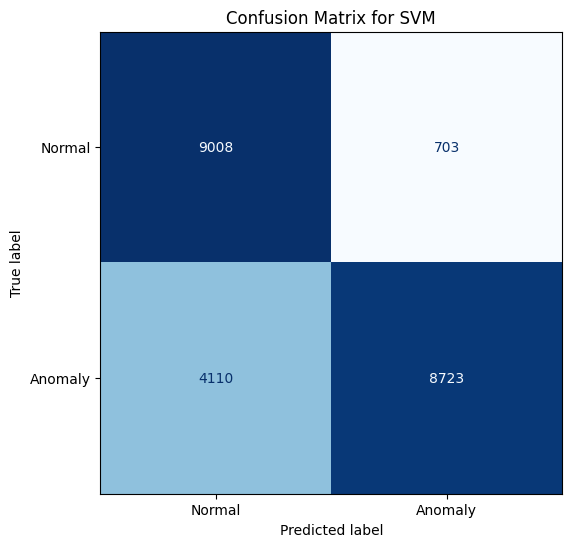

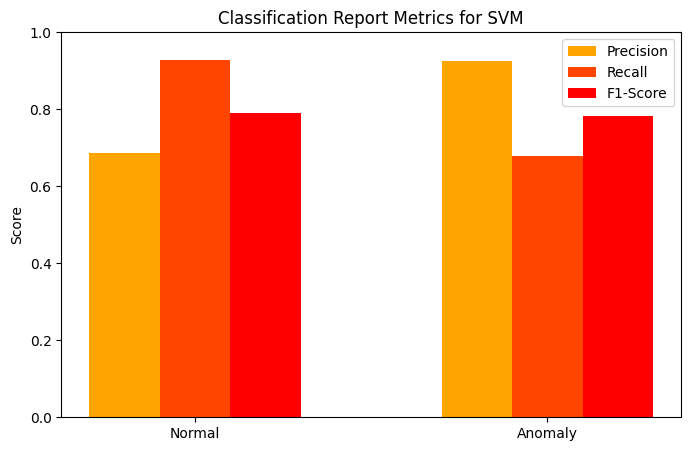

In [5]:
#Train an SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

#run the svm model on test set
y_pred_svm = svm_model.predict(X_test_scaled)

#create confusion matrix to measure the results
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm, labels=['normal', 'anomaly'])
report_svm = classification_report(y_test, y_pred_svm, labels=['normal', 'anomaly'], output_dict=True)


print("Confusion Matrix (Numbers Only):")
print(conf_matrix_svm)

#Create some nice graphs :)
print("\nClassification Metrics:")
print(f"Precision (Normal): {report_svm['normal']['precision']:.2f}")
print(f"Recall (Normal): {report_svm['normal']['recall']:.2f}")
print(f"F1-Score (Normal): {report_svm['normal']['f1-score']:.2f}")
print(f"Precision (Anomaly): {report_svm['anomaly']['precision']:.2f}")
print(f"Recall (Anomaly): {report_svm['anomaly']['recall']:.2f}")
print(f"F1-Score (Anomaly): {report_svm['anomaly']['f1-score']:.2f}")


fig, ax = plt.subplots(figsize=(6, 6))
labels = ['Normal', 'Anomaly']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix for SVM")
plt.show()


metrics_svm = {
    'Class': ['Normal', 'Anomaly'],
    'Precision': [report_svm['normal']['precision'], report_svm['anomaly']['precision']],
    'Recall': [report_svm['normal']['recall'], report_svm['anomaly']['recall']],
    'F1-Score': [report_svm['normal']['f1-score'], report_svm['anomaly']['f1-score']]
}


fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(metrics_svm['Class']))
width = 0.2

ax.bar(x - width, metrics_svm['Precision'], width, label='Precision', color='orange')
ax.bar(x, metrics_svm['Recall'], width, label='Recall', color='orangered')
ax.bar(x + width, metrics_svm['F1-Score'], width, label='F1-Score', color='red')

ax.set_xticks(x)
ax.set_xticklabels(metrics_svm['Class'])
ax.set_ylim(0, 1)
ax.set_title("Classification Report Metrics for SVM")
ax.set_ylabel("Score")
ax.legend()

plt.show()


Confusion Matrix for Random Forest:
 [[9443  268]
 [4747 8086]]

Classification Report for Random Forest:
Precision (Normal): 0.67
Recall (Normal): 0.97
F1-Score (Normal): 0.79
Precision (Anomaly): 0.97
Recall (Anomaly): 0.63
F1-Score (Anomaly): 0.76


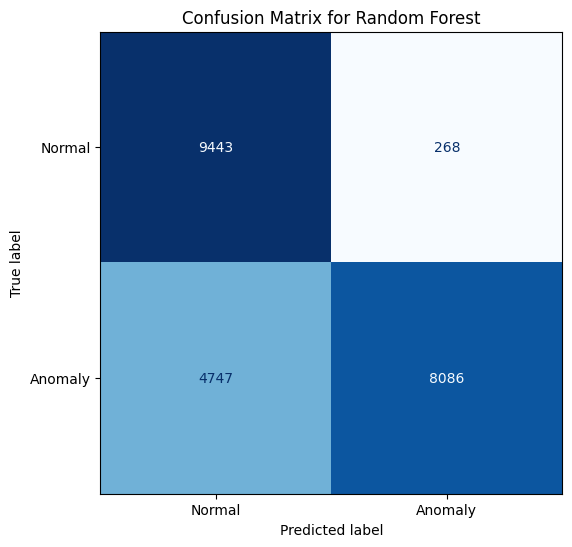

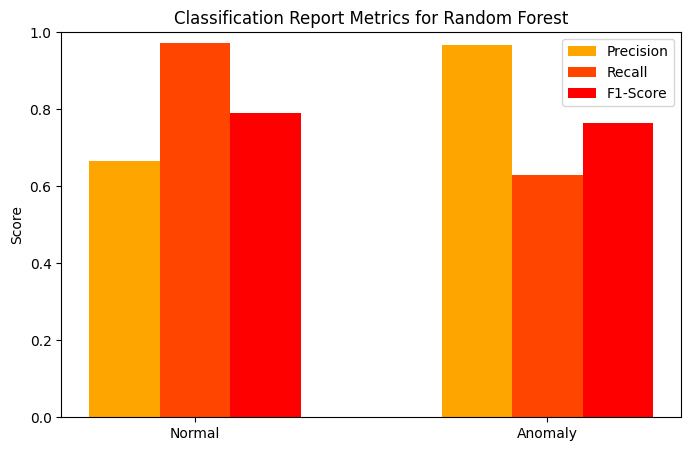

In [6]:
#train a Random Forest Classifier with 100 estimators as a common default value
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) 
rf_model.fit(X_train_scaled, y_train)

#run random forest on test set
y_pred_rf = rf_model.predict(X_test_scaled)

#create confusion matrix to measure performance
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf, labels=['normal', 'anomaly'])
report_rf = classification_report(y_test, y_pred_rf, labels=['normal', 'anomaly'], output_dict=True)

#Some mroe nice graphs !
print("Confusion Matrix for Random Forest:\n", conf_matrix_rf)
print("\nClassification Report for Random Forest:")
print(f"Precision (Normal): {report_rf['normal']['precision']:.2f}")
print(f"Recall (Normal): {report_rf['normal']['recall']:.2f}")
print(f"F1-Score (Normal): {report_rf['normal']['f1-score']:.2f}")
print(f"Precision (Anomaly): {report_rf['anomaly']['precision']:.2f}")
print(f"Recall (Anomaly): {report_rf['anomaly']['recall']:.2f}")
print(f"F1-Score (Anomaly): {report_rf['anomaly']['f1-score']:.2f}")


fig, ax = plt.subplots(figsize=(6, 6))
labels = ['Normal', 'Anomaly']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix for Random Forest")
plt.show()


metrics_rf = {
    'Class': ['Normal', 'Anomaly'],
    'Precision': [report_rf['normal']['precision'], report_rf['anomaly']['precision']],
    'Recall': [report_rf['normal']['recall'], report_rf['anomaly']['recall']],
    'F1-Score': [report_rf['normal']['f1-score'], report_rf['anomaly']['f1-score']]
}


fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(metrics_rf['Class']))
width = 0.2

ax.bar(x - width, metrics_rf['Precision'], width, label='Precision', color='orange')
ax.bar(x, metrics_rf['Recall'], width, label='Recall', color='orangered')
ax.bar(x + width, metrics_rf['F1-Score'], width, label='F1-Score', color='red')

ax.set_xticks(x)
ax.set_xticklabels(metrics_rf['Class'])
ax.set_ylim(0, 1)
ax.set_title("Classification Report Metrics for Random Forest")
ax.set_ylabel("Score")
ax.legend()

plt.show()

